In [4]:
import sys 
sys.path.append("../../")

from crossbeam.abstraction.dreamcoder2lambdabeam import *
from crossbeam.abstraction.lambdabeam2dreamcoder import *
import torch
import re
from crossbeam.abstraction.utils import *
from collections import OrderedDict
from crossbeam.dsl.deepcoder_utils import run_program


In [1]:
a = {'Add': 0, 'Subtract': 1, 'Multiply': 2, 'IntDivide': 3, 'Square': 4, 'Min': 5, 'Max': 6, 'Greater': 7, 'Less': 8, 'Equal': 9, 'IsEven': 10, 'IsOdd': 11, 'If': 12, 'Head': 13, 'Last': 14, 'Take': 15, 'Drop': 16, 'Access': 17, 'Minimum': 18, 'Maximum': 19, 'Reverse': 20, 'Sort': 21, 'Sum': 22, 'Map': 23, 'Filter': 24, 'Count': 25, 'ZipWith': 26, 'Scanl1': 27}

In [2]:
len(a)

28

In [5]:
import torch
with open("/work/ldierkes/repos/new/LambdaBeam/outputs/abstractbeam/model-best-valid.ckpt", "rb") as f:
    ckpt = torch.load(f)
base_function_dict = ckpt["base_function_dict"]
higher_order_functions = ckpt["higher_order_functions"]

In [40]:
parse_abstraction("(lam (Cons (Car (#0 $0))))", base_function_dict, higher_order_functions = {"Map": [1,0], "Fold": [2,0,0]})

Cons(Car(x1), x2)


('Cons(Car(x1), x2)',
 OrderedDict([('x1', [0, ['Car']]), ('x2', [0, ['Cons']])]))

In [39]:
import re
from collections import OrderedDict
parse_abstraction("(Cons (Car #1))", base_function_dict, higher_order_functions = {"Map": [1,0], "Fold": [2,0,0]})

Cons(Car(x1), x2)


('Cons(Car(x1), x2)',
 OrderedDict([('x1', [0, ['Car']]), ('x2', [0, ['Cons']])]))

In [37]:
for inv in ckpt["inventions"]:
    if "x1" not in inv.program:
        print(inv.name, inv.program)

fn_12 Cons(Car(x2), x3)
fn_35 fn_3(x2, Cons(Car(Cdr(x2)), x3))


In [14]:
def parse_abstraction(abstraction, base_function_dict, higher_order_functions = {"Map": [1,0], "Fold": [2,0,0]}):
    tokens = [token for token in re.findall(r'-?\b\w+\b|\#\d||\$\d|[():+-]', abstraction) if token.strip()]
    local_vars = ["v", "u", "p", "q", "r", "s", "t", "w", "y", "z"]
    local_var_counter = -1
    open_parentheses_count = 0
    local_var_parentheses = []
    bound_variables_dict = OrderedDict()
    max_hashtag_var = find_max_global_var(abstraction, pattern='#(\d+)')
    result_string = ""
    arguments_counter = OrderedDict()
    if tokens[0] == "(" and tokens[1] == "lam":
        tokens = tokens[2:-1]
    for i, token in enumerate(tokens):
        if token == "(":
            open_parentheses_count += 1

            result_string += token

        elif token == ")":
            if len(local_var_parentheses) > 0 and local_var_parentheses[-1] == open_parentheses_count:
                local_var_parentheses.pop()
                local_var_counter -= 1
            open_parentheses_count -= 1
            
            result_string += token
            if i != len(tokens)-1 and tokens[i+1] != ")" and tokens[i+1] != "," and tokens[i-1] != "(":
                result_string += ","

            
        elif token in base_function_dict.keys():
            result_string = result_string[:-1] + token + result_string[-1]
            if len(arguments_counter) > 0:
                arguments_counter[list(arguments_counter.items())[-1][0]] -= 1
            if len(arguments_counter) > 0 and arguments_counter[list(arguments_counter.items())[-1][0]] == 0:
                arguments_counter.popitem()
            arguments_counter[token] = base_function_dict[token]

        elif token == "lam" or token == "lambda":
            local_var_counter += 1
            local_var_parentheses.append(open_parentheses_count)

            result_string += f"lambda {local_vars[local_var_counter]}1: "
            
        # replace variables
        elif (token[0] == "$" or token[0] == "#") and token[1:].isdigit():

            # var is a function
            if tokens[i-1] == "(":
                func_name = "x" + str(int(token[1:]) + 1) if token[0] == "#" else "x" + str(int(token[1:]) + 2 + max_hashtag_var)
                result_string = result_string[:-1] + func_name + result_string[-1]
                if len(arguments_counter) > 0:
                    arguments_counter[list(arguments_counter.items())[-1][0]] -= 1

                # add arguments to arguments_counter
                arguments_counter[func_name] = count_arity(tokens, i-1, base_function_dict)[0] - 1
                

            elif token[0] == "#":
               result_string += "x" + str(int(token[1:]) + 1)
               
            elif token[0] == "$":
                if int(token[1:]) <= local_var_counter:
                    result_string += str(local_vars[local_var_counter - int(token[1:])]) + "1"
                else:
                    result_string += "x" + str(int(token[1:]) - local_var_counter - 1 + max_hashtag_var + 2)
            
            if i != len(tokens)-1 and tokens[i+1] != ")" and tokens[i+1] != "," and tokens[i-1] != "(":
                result_string += ","
            
            if len(arguments_counter) > 0:
                arguments_counter[list(arguments_counter.items())[-1][0]] -= 1
        elif token.isdigit() or (token[0] == "-" and token[1:].isdigit()) or token == "empty":
            if token == "empty":
                result_string += "[]"
            else:
                result_string += token
            if len(arguments_counter) > 0:
                arguments_counter[list(arguments_counter.items())[-1][0]] -= 1
            
            if i != len(tokens)-1 and tokens[i+1] != ")" and tokens[i+1] != "," and tokens[i-1] != "(":
                result_string += ","
    
    
    # add missing arguments     
    result_string = add_missing_args(result_string, base_function_dict)
    # remove precedings lambdas 
    result_string = remove_lambdas(result_string, base_function_dict)
    # add necessary spaces 
    result_string = result_string.replace("lambda", "lambda ")
    result_string = result_string.replace(":", ": ")
    result_string = result_string.replace(",", ", ")
    # remove outer x functions
    result_string = remove_outer_x_functions(result_string)

    # remove unnecessary x functions
    result_string = remove_unnecessary_x_functions(result_string)

    # check variable ordering
    result_string = check_variable_ordering(result_string)

    # calculate bound variables
    bound_variables_dict = calculate_bound_variables_dict(result_string, base_function_dict, higher_order_functions)
    # correct double lambdas
    result_string = correct_double_lam(result_string)
    

    return result_string, bound_variables_dict

In [7]:
import torch
with open("/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/model-best-valid.ckpt", "rb") as f:
    ckpt_1 = torch.load(f)

In [89]:
for inv in ckpt["inventions"]:
    print(inv.name, inv.program)

fn_0 Cdr(Cdr(x1))
fn_2 x1(Cdr(Cdr(x2)))
fn_3 Cons(Car(x1), x2)
fn_6 fn_0(Cdr(x1))
fn_9 Map((lambda v1: Mod(v1, x1)), x2)
fn_10 Cons(Car(x1(x2)), x3)
fn_11 Map((lambda v1: x1(1, v1)), x2)
fn_12 Cons(Car(x2), x3)
fn_15 Index(Add(1, 1), x1)
fn_17 x1(fn_0(Cdr(x2)))
fn_18 Add(1, x1)
fn_21 fn_9(Add(1, x2), fn_11(x1, x3))
fn_22 Cons(fn_15(x1), x2)
fn_23 x1(x3, x2(Cdr(x3), x1(fn_0(x3), [])))
fn_29 Map((lambda v1: x2(Cdr(x1))), x1)
fn_30 Subtract(1, x1)
fn_32 Cons(Car(Cdr(x1)), x2)
fn_33 fn_9(x2, Map((lambda v1: x1(v1)), x3))
fn_35 fn_3(x2, Cons(Car(Cdr(x2)), x3))
fn_38 fn_9(x2, fn_11(x1, x3))
fn_41 Cons(Car(x1), [])
fn_45 Add(2, x1)
fn_52 If(x1, 1, 0)
fn_55 fn_9(3, fn_11((lambda u1, v1: (())), x1))
fn_56 fn_32(x2, fn_22(x2, x1))
fn_57 Map((lambda v1: 0), x1)
fn_59 fn_3(x3, fn_56(x2(x1(x3)), x3))
fn_61 Cons(fn_15(fn_0(x1)), fn_41(fn_6(fn_0(x1))))
fn_63 If(Greater(fn_9(2, x1), x2(x1)), x4, x3)
fn_67 fn_11((lambda u1, v1: (fn_52(Greater(v1, x1)))), x2)
fn_77 fn_67(x1, x2)
fn_79 fn_9(3, x1)
fn_80 

In [2]:
programs = ['(lam (map (lam (+ 1 $0)) $0))',
 '(lam (map (lam (+ 1 (+ 1 (+ 1 $0)))) $0))',
 '(lam (map (lam (+ 1 (+ 1 (+ 1 $0)))) $0))',
 '(lam (fold $0 (cons (car (cdr $0)) empty) (lam (lam (cons $1 $0)))))',
 '(lam (fold $0 (cons (car (cdr (cdr $0))) empty) (lam (lam (cons $1 $0)))))',
 '(lam (fold (cons (car (cdr (cdr (cdr $0)))) empty) $0 (lambda (lambda (cons $1 $0)))))',
 '(lam (fold $0 (cons 0 empty) (lam (lam (cons $1 $0)))))',
 '(lambda (fold (cons (+ 1 (+ 1 1)) empty) $0 (lambda (lambda (cons $1 $0)))))',
 '(lam (fold $0 (cons (+ 1 (+ 1 (+ 1 1))) empty) (lam (lam (cons $1 $0)))))',
 '(lam (fold (cons $0 empty) (+ 1 (+ 1 (+ 1 (+ 1 1)))) (lambda (lambda (cons $1 $0)))))',
 '(lam (map (lam (gt? (+ 1 $0) 0)) $0))',
 '(lam (map (lam (gt? $0 0)) $0))',
 '(lam (map (lam (gt? $0 (+ 1 (+ 1 $0 )))) $0))',
 '(lam (map (lam (gt? 1 (mod $0 (+ 1 (+ 1 1))))) $0))',
 '(lam (map (lam (gt? 1 (mod $0 (+ 1 (+ 1 (+ 1 1)))))) $0))',
 '(lam (map (lam (eq? $0 (+ 1 (+ 1 1)))) $0))',
 '(lam (map (lam (eq? $0 (+ 1 (+ 1 (+ 1 1))))) $0))',
 '(lam (map (lam (- 1 $0)) $0))',
 '(lam (map (lam (mod (+ 1 $0) (+ 1 (+ 1 1)))) $0))',
 '(lam (map (lam (mod (+ 1 $0) (+ 1 (+ 1 (+ 1 (+ 1 1)))))) $0))',
 '(lam (map (lam (mod (+ 1 (+ 1 (+ 1 $0))) (+ 1 (+ 1 (+ 1 1))))) $0))',
 '(lam (map (lam (if (is-prime $0) 0 (+ 1 $0))) $0))',
 '(lam (map (lam (- 1 $0)) $0))',
 '(lam (map (lam (index $0 (cons (+ 1 1) (cons 0 (cons 1 empty))))) $0))',
 '(lam (map (lam (if (is-prime (- $0 1)) 0 (+ $0 1))) $0))',
 '(lam (fold (cdr $0) 0 (lam (lam (if (eq? $1 (car $2)) (+ 1 $0) $0)))))',
 '(lam (fold $0 0 (lambda (lambda (cons $1 $0)))))',
 '(lam (fold $0 (+ 1 (+ 1 1)) (lambda (lambda (cons $1 $0)))))',
 '(lam (fold $0 0 (lam (lam (if (eq? $1 (+ 1 (+ 1 (+ 1 (+ 1 1))))) (+ 1 $0) $0)))))',
 '(lam (cdr (cdr (cdr $0))))',
 '(lam (cdr (cdr (cdr (cdr (cdr $0))))))',
 '(lam (empty? $0))',
 '(lam (fold $0 empty (lambda (lambda (if (eq? (mod $1 (+ 1 1)) 0) (cons $1 $0) $0)))))',
 '(lam (is-square (+ 1 (mod (car $0) (index (length (cdr (cdr $0))) $0)))))',
 '(lam (gt? 1 (fold $0 1 (lam (lam (* $0 $1))))))',
 '(lam (gt? (fold $0 (+ 1 (+ 1 1)) (lambda (lambda (cons $1 $0)))) 0))',
 '(lam (eq? (+ 1 (+ 1 (+ 1 (+ 1 1)))) (index (length $0) (cons 1 $0))))',
 '(lam (car $0))',
 '(lam (car $0))',
 '(lam (index 1 (cdr $0)))',
 '(lam (car (cdr (cdr (cdr (cdr $0))))))',
 '(lam (fold $0 empty (lambda (lambda (if (is-prime (+ (+ 1 (+ 1 (+ 1 1))) $1)) (cons $1 $0) $0)))))',
 '(lam (eq? (fold (map (lam (mod (+ 1 $0) (+ 1 (+ 1 1)))) $0) 1 (lambda (lambda (* $0 $1)))) 1))',
 '(lam (fold $0 (empty? empty) (lam (lam (if $0 (is-prime $1) $0)))))',
 '(lam (fold $0 empty (lambda (lambda (if (empty? (fold $1 empty (lambda (lambda (if (gt? $0 $1) (cons $1 $0) $0))))) (cons $1 $0) $0)))))',
 '(lam (index (length (cdr $0)) $0))',
 '(lam (length $0))',
 '(lam (map (lam 0) $0))',
 '(lam (map (lam (mod $0 (+ 1 1))) $0))',
 '(lam (map (lam (mod $0 (+ (+ 1 1) 1))) $0))',
 '(lam (map (lam (mod $0 (+ 1 (+ 1 (+ 1 1))))) $0))',
 '(lam (map (lam (mod $0 (+ 1 (+ 1 (+ 1 (+ 1 1)))))) $0))',
 '(lam (map (lam 0) $0))',
 '(lam (map (lam (+ $0 $0)) $0))',
 '(lam (map (lam (+ $0 (+ $0 $0))) $0))',
 '(lam (map (lam (* $0 (+ 1 (+ 1 (+ 1 (+ 1 1)))))) $0))',
 '(lam (fold $0 empty (lambda (lambda (if (lam (gt? (mod $1 (+ 1 1)) 0)) (cons $1 $0) $0)))))',
 '(lam (cons (car $0) $0))',
 '(lam (cons (car (cdr $0))$0))',
 '(lam (cons (car (cdr (cdr (cdr $0)))) $0))',
 '(lam (cons 0 $0))',
 '(lam (fold $0 1 (lam (lam (* $0 $1)))))',
 '(lam (cons (car $0) (cdr (cdr $0))))',
 '(lam (cons (car $0) (cons (car (cdr $0)) (cons (car (cdr (cdr $0))) (cdr (cdr (cdr (cdr $0))))))))',
 '(lam (fold $0 empty (lambda (lambda (if (lam (is-prime (mod (+ $1 $1) (+ 1 (+ 1 (+ 1 1)))))) (cons $1 $0) $0)))))',
 '(lam (fold $0 empty (lam (lam (if (is-square (mod (+ 1 (+ 1 $1)) (+ 1 (+ 1 1)))) (cons $1 $0) $0)))))',
 '(lam (fold $0 $0 (lam (lam (cons $1 $0)))))',
 '(lam (map (lam (car $1)) $0))',
 '(lam (map (lam (car (cdr (cdr (cdr $1))))) $0))',
 '(lam (fold $0 empty (lam (lam (fold $0 (cons $1 empty) (lambda (lambda (cons $1 $0))))))))',
 '(lam (cons (car $0) empty))',
 '(lam (cons (car $0) (cons (car (cdr $0)) (cons (car (cdr (cdr $0))) (cons (car (cdr (cdr (cdr $0)))) empty)))))',
 '(lam (cons (car (cdr $0)) (cons (car (cdr (cdr $0))) empty)))',
 '(lam (cons (car (cdr $0)) (cons (car (cdr (cdr $0))) (cons (car (cdr (cdr (cdr $0)))) empty))))',
 '(lam (cons (car (cdr $0)) (cons (car (cdr (cdr $0))) (cons (car (cdr (cdr (cdr $0)))) (cons (car (cdr (cdr (cdr (cdr $0))))) (cons (car (cdr (cdr (cdr (cdr (cdr $0))))))empty))))))',
 '(lam (cons (car (cdr (cdr $0)))(cons (car (cdr (cdr (cdr $0)))) (cons (car (cdr (cdr (cdr (cdr $0))))) empty))))',
 '(lam (cons (car (cdr (cdr $0))) (cons (car (cdr (cdr (cdr $0)))) (cons (car (cdr (cdr (cdr (cdr $0))))) (cons (car (cdr (cdr (cdr (cdr (cdr $0)))))) empty)))))',
 '(lam (fold (cdr (cdr $0)) $0 (lam (lam (cons $1 (cons (car $0) (cons (car (cdr $0)) (cons (car (cdr (cdr $0))) (cons (car (cdr (cdr (cdr $0))))empty)))))))))',
 '(lam (cons (car (cdr (cdr (cdr $0)))) empty))',
 '(lam (cons (car (cdr (cdr (cdr $0))))(cons (car (cdr (cdr (cdr (cdr $0))))) (cons (car (cdr (cdr (cdr (cdr (cdr $0)))))) empty))))',
 '(lam (cons (car (cdr (cdr (cdr $0))))(cons (car (cdr (cdr (cdr (cdr $0))))) (cons (car (cdr (cdr (cdr (cdr (cdr $0)))))) (cons (car (cdr (cdr (cdr (cdr (cdr (cdr $0))))))) (cons (car (cdr (cdr (cdr (cdr (cdr (cdr (cdr $0))))))))empty))))))',
 '(lam (cons (car (cdr (cdr (cdr (cdr $0))))) (cons (car (cdr (cdr (cdr (cdr (cdr $0)))))) empty)))',
 '(lam (cons (car (cdr (cdr (cdr (cdr $0))))) (cons (car (cdr (cdr (cdr (cdr (cdr $0)))))) (cons (car (cdr (cdr (cdr (cdr (cdr (cdr $0))))))) (cons (car (cdr (cdr (cdr (cdr (cdr (cdr (cdr $0))))))))empty)))))',
 '(lam (cdr $0))',
 '(lam (cons (car $0) empty))',
 '(lam (cons (car $0) (cons (car (cdr $0)) empty)))',
 '(lam (cons (car $0) (cons (car (cdr $0)) (cons (car (cdr (cdr $0))) empty))))',
 '(lam (cons (car $0) (cons (car (cdr $0)) (cons (car (cdr (cdr $0))) (cons (car (cdr (cdr (cdr $0))))empty)))))',
 '(lam (+ 1 (fold $0 1 (lam (lam (if (gt? $0 $1) $0 $1))))))',
 '(lam (fold $0 empty (lambda (lambda (if (is-square $1) (cons $1 $0) $0)))))',
 '(lam (fold $0 empty (lam (lam (if (is-prime $1) (cons $1 $0) $0)))))',
 '(lam (fold $0 empty (lambda (lambda (if (gt? $1 0) (cons $1 $0) $0)))))',
 '(lam (fold $0 $0 (lam (lam (if (eq? $1 0) $0 (cdr (map (lam 0) $0)))))))',
 '(lam (fold $0 $0 (lam (lam (if (eq? $1 1) $0 (cdr (map (lam 1) $0)))))))',
 '(lam (fold $0 empty (lam (lam (if (gt? $1 1) (cons $1 $0) $0)))))',
 '(lam (fold $0 empty (lambda (lambda (if (gt? (+ 1 (+ 1 1)) $1) (cons $1 $0) $0)))))',
 '(lam (fold $0 empty (lambda (lambda (if (gt? $1 (+ 1 (+ 1 1))) (cons $1 $0) $0)))))']

In [7]:
t = {'+': "Add",
 '-': "Subtract",
 '*': "Multiply",
 'gt?': "Greater",
 'eq?': "Equal",
 'if': "If",
 'fold': "Fold",
 'map': "Map",
 'is-empty': "IsEmpty",
 'cons': "Cons",
 'car': "Car",
 'cdr': "Cdr",
 'is-square': "IsSquare",
 'is-prime': "IsPrime",
 'length': "Length",
 'index': "Index",
 'mod': "Mod"}


In [ ]:
# pickle programs
import pickle
with open("base_programs.pkl", "wb") as f:
    pickle.dump(programs, f)

In [3]:
from stitch_core import *
res = compress(programs, iterations=1000, max_arity=3)

In [10]:
for abs in res.abstractions:
    for func in t.keys():
        abs.body = abs.body.replace(func, t[func])

In [ ]:
(fn_7 (lam (lam (if (#0 $0) (cons $0 $0) $0))))
(lam (fold $0 empty (lam (lam (if (#0 $0) (cons $0 $0) $0)))))

In [1]:
res.abstractions

NameError: name 'res' is not defined

In [11]:
from crossbeam.abstraction.dreamcoder2lambdabeam import *
a = rewrite_abstractions(res.abstractions, get_function_dict())

In [12]:
a

[fn_0(#0) := (cons (car #0) (cons (car (cdr #0)) (cons (car (cdr (cdr #0))) empty))),
 fn_1(#0) := (+ 1 (+ 1 #0)),
 fn_2(#0,#1) := (cons (car #0) (#1 (cdr #0))),
 fn_3(#0,#1) := (fold #1 #0 (lam (lam (cons $1 $0)))),
 fn_4(#0,#1) := (lam (if #1 (cons #0 $0) $0)),
 fn_5(#0) := (lam (map #0 $0)),
 fn_6(#0) := (cdr (cdr #0)),
 fn_7(#0) := (lam (fold $0 empty #0)),
 fn_8() := (+ 1),
 fn_9() := (+ 1 (+ 1 1)),
 fn_10(#0) := (cons (car (cdr #0))),
 fn_11(#0) := (lam (fold $0 $0 (lam (lam (if (eq? $1 #0) $0 (cdr (map (lam #0) $0))))))),
 fn_12(#0) := (cons #0 empty),
 fn_13(#0,#1) := (cons (car #1) (cons (car (cdr #1)))),
 fn_14(#0,#1) := (lam (map (lam (#1 $0 #0)) $0)),
 fn_15(#0) := (fold #0 1 (lam (lam (* $0 $1)))),
 fn_16(#0) := (lam (fold $0 empty (lam (lam (if (gt? $0 #0) (cons $0 $0) $0))))),
 fn_17(#0,#1) := (fold #1 0 (lam (lam (if (eq? $1 #0) (+ 1 $0) $0)))),
 fn_18(#0) := (lam (fold $0 empty (lam (lam (if (#0 $0) (cons $0 $0) $0))))),
 fn_19() := (+ 1 (+ 1 (+ 1 1))),
 fn_20(#0) := (

In [1]:
import torch
from crossbeam.abstraction.dreamcoder2lambdabeam import *
with open("/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/model-latest.ckpt", "rb") as f:
    ckpt = torch.load(f)
base_function_dict = ckpt["base_function_dict"]
higher_order_functions = ckpt["higher_order_functions"]
model = ckpt["model"]
optimizer = ckpt["optimizer"]
domain = ckpt["domain"]
# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
domain.constants

[0, 1, []]

In [2]:
import random
from crossbeam.dsl.deepcoder_utils import run_program


gram("x1(Mod(x2, Add(1, 1)), 0)", {"x1": [lambda x,y: x +y], "x2": [3]})

[1]

In [8]:
[1,2,3] < [4]

True

In [3]:
 
lambdabeam_programs = [
    ["Cons(Car(x1), Cons(Car(Cdr(x1)), Cons(Car(Cdr(Cdr(x1))), [])))", [0]],
    ["Cons(Car(x2), x1(Cdr(x2)))",[1, 0]],
    ["If(x2, Cons(x1, x3), x3)",[0, 0, 0]],
    ["Cons(Car(Cdr(x1)), x2)",[0, 0]],
    ["Cdr(Cdr(x1))", [0]],
    ["Cons(Car(Cdr(x1)), x2)", [0, 0]],
    ["Cons(x1, [])", [0]],
    ["Add(1, Add(1, x1))", [0]],
    ["Add(1, x1)", [0]],
    ["Cons(Car(x1), Cons(Car(Cdr(x1)), x2))", [0, 0]],
    ["Fold((lambda u1, u2: Cons(u2, u1)), x2, x1)", [0, 0]], # Extend 
    ["Fold(x1, [], x2)", [2, 0]],
    ["Fold((lambda u1, u2: If(Equal(u2, x2), u1, Cdr(Map((lambda v1: x2), u1)))), x1, x1)", [0, 0]], # Filter Equal ?
    ["Fold((lambda u1, u2: If(Equal(u2, x2), Add(1, u1), u1)), 0, x1)", [0, 0]],  # COUNT
    ["Fold((lambda u1, u2: If(Greater(u2, x2), Cons(u2, u1), u1)), [], x1)", [0, 0]], # Filter Smaller
    ["Fold((lambda u1, u2: Multiply(u1, u2)), 1, x1)", [0]], # PRODUCT
    ["Fold((lambda u1, u2: If(x2(u1), Cons(u2, u1), u1)), [], x1)", [0, 1]], # FILTER
    ["Fold((lambda u1, u2: Cons(u2, u1)), Cons(x2, []), x1)", [0, 0]], # Append
    ["Cons(Car(x1), x2(Cdr(x1)))", [0, 1]], 
    ["Cdr(Cdr(Cdr(Cdr(x1))))", [0]],
    ["Add(1, Add(1, x1))", [0]],
    ["Mod(Add(1, x1), x2)", [0, 0]],
    ["Map((lambda u1: Greater(1, Mod(u1, x2))), x1)", [0, 0]],
    ["Map((lambda u1: Add(1, Add(1, Add(1, u1)))), x1)", [0]],
    ["Map((lambda u1: Subtract(1, u1)), x1)", [0]],
    ["Cons(Car(x1), [])", [0]],
    ["Index(Length(x1(x2)), x2)", [1, 0]],
    ["Greater(0, x1)", [0]],
    ["Cons(Car(Cdr(Cdr(Cdr(x1)))), x2)", [0, 0]],
    ["If(IsPrime(x1), 0, x2)", [0,0]],
    ["x1(Mod(x2, Add(1, 1)), 0)", [2, 0]],
    ["Map((lambda u1: 0), x1)", [0]],
    ["Mod(Add(1, x1), x2)", [0, 0]],
    ["Cons(0, x1)", [0]],
    ["Cons(Car(x1), Cons(Car(Cdr(x1)), x2))", [0, 0]], 
    ["Map((lambda u1: Car(x1)), x2)", [0, 0]]
]

        
inventions = []
for i, program in enumerate(lambdabeam_programs):
    if sum(program[1]) > 0:
        higher_order_functions[f"fn_{i}"] = program[1]
    base_function_dict[f"fn_{i}"] = len(program[1])
    #inventiona = Inventiona(f"fn_{i}", program[0])
    new_op = Invented(len(program[1]), program[0], invention=f"fn_{i}", bound_variables = program[1], dc_prims = True, inventions= [])
    outer_op = get_outer_op(program[0], base_function_dict)
    model.add_invention(f"fn_{i}", outer_op, func_for_args = [], device = device, initialization_method = "top")
    inventions.append(new_op)
    domain.operations.append(new_op)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)


In [27]:
convert("Fold((lambda u1, u2: If(Equal(u2, x2), u1, Cdr(Map((lambda v1: x2), u1)))), x1, x1)", get_function_dict(), {"Map": [1,0], "Fold": [2,0,0]})

'(lambda (Fold (lambda (lambda (If (Equal $1 $3)$0 (Cdr (Map (lambda $4)$0)))))$0 $0))'

In [28]:
parse_abstraction('(lam (Fold (lambda (lambda (If (Equal $1 $3)$0 (Cdr (Map (lambda $4)$0)))))$0 $0))'
, get_function_dict())

('Fold((lambda u1, v1: (If(Equal(v1, x2), u1, Cdr(Map((lambda p1: x2), u1))))), x1, x1)',
 OrderedDict([('x2', [0, ['Equal', 'Map']]), ('x1', [0, ['Fold', 'Fold']])]))

In [14]:
# pickle invention list
import pickle
with open("all_inventions.pkl", "wb") as f:
    pickle.dump(inventions, f)


In [ ]:
class Inventiona:
    def __init__(self, name, program):
        self.name = name
        self.program = program
    

In [2]:
domain.constants.append(2)
domain.constants.append(3)

In [12]:
domain.operations[-6].arity

2

In [3]:
isinstance(False, int) is True

True

In [114]:
domain.operations[-20].program = 'Fold((lambda u1, u2: If(x2(u2), Cons(u2, u1), u1)), [], x1)'

In [3]:
checkpoint = {
    'step': ckpt["step"],
    'model': ckpt["model"],
    'optimizer': ckpt["optimizer"],
    'inventions': ckpt["inventions"],
    "higher_order_functions": ckpt["higher_order_functions"],
    "base_function_dict": ckpt["base_function_dict"],
    "dc_abstractions": ckpt["dc_abstractions"],
    "domain": domain,
    "frontiers": ckpt["frontiers"]
}

In [4]:
torch.save(checkpoint, "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/model-latest.ckpt")

In [7]:
[[0, 0], [0, -13], [1, 5], [2, 3], [3, -1], [4, 1], [6, 0], [12, 12], [41, 4], [-1, 2], [-200, -26]] + [[[], [1]], [[2], []], [[], [0]], [[1], [5]], [[14, 12, 12], [51, 31, 21]], [[1, 2, 3], [2]], [[], [1, 2, 3, 4]], [[1, 2, 3, 4], []], [[1, 2, 3, 4], [1, 2, 3, 4]], [0, [1, 2, 3, 4]], [5, [3, 45, 9, 10]], [[1, 2, 3, 4], 2]]

[[0, 0],
 [0, -13],
 [1, 5],
 [2, 3],
 [3, -1],
 [4, 1],
 [6, 0],
 [12, 12],
 [41, 4],
 [-1, 2],
 [-200, -26],
 [[], [1]],
 [[2], []],
 [[], [0]],
 [[1], [5]],
 [[14, 12, 12], [51, 31, 21]],
 [[1, 2, 3], [2]],
 [[], [1, 2, 3, 4]],
 [[1, 2, 3, 4], []],
 [[1, 2, 3, 4], [1, 2, 3, 4]],
 [0, [1, 2, 3, 4]],
 [5, [3, 45, 9, 10]],
 [[1, 2, 3, 4], 2]]

#### Handwritten abstractions
Constants: [-1, 0, 1, 2, 3, 4, 5]

Functions:
- Fold((lambda u1, v1: (Cons(v1, u1))), x2, x1)
- Cons(Car(x1), Cons(Car(Cdr(x1)), Cons(Car(Cdr(Cdr(x1))), [])))
- Cons(Car(x1), x2(Cdr(x1)))
- If(x2, Cons(x1, x3), x3)
- Cons(Car(Cdr(x1)), x2)
- Fold(x2, [], x1)
- Cdr(Cdr(x1))
- Cons(Car(Cdr(x1)), x2)
- Cons(x1, [])

In [ ]:
parse_abstraction("(Cons #0 empty)", get_function_dict(), {"Map": [1,0], "Fold": [2,0,0]})

In [60]:
ckpt["domain"].operations

[Add,
 Subtract,
 Multiply,
 Greater,
 Mod,
 Equal,
 IsEmpty,
 IsSquare,
 IsPrime,
 If,
 Cdr,
 Car,
 Length,
 Cons,
 Index,
 Map,
 Fold,
 fn_0,
 fn_6,
 fn_15,
 fn_16,
 fn_17,
 fn_20,
 fn_36,
 fn_37,
 fn_49,
 fn_53]

In [1]:
import torch
with open("/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/model-best-valid.ckpt", "rb") as f:
    ckpt = torch.load(f)

invention_names = [inv.name for inv in ckpt["inventions"]]

In [2]:
for inv in ckpt["inventions"]:
    print(inv.name, inv.program)

fn_0 Cdr(Cdr(x1))
fn_2 x1(Cdr(Cdr(x2)))
fn_3 Cons(Car(x1), x2)
fn_6 fn_0(Cdr(x1))
fn_9 Map((lambda v1: Mod(v1, x1)), x2)
fn_10 Cons(Car(x1(x2)), x3)
fn_11 Map((lambda v1: x1(1, v1)), x2)
fn_12 Cons(Car(x2), x3)
fn_15 Index(Add(1, 1), x1)
fn_17 x1(fn_0(Cdr(x2)))
fn_18 Add(1, x1)
fn_21 fn_9(Add(1, x2), fn_11(x1, x3))
fn_22 Cons(fn_15(x1), x2)
fn_23 x1(x3, x2(Cdr(x3), x1(fn_0(x3), [])))
fn_29 Map((lambda v1: x2(Cdr(x1))), x1)
fn_30 Subtract(1, x1)
fn_32 Cons(Car(Cdr(x1)), x2)
fn_33 fn_9(x2, Map((lambda v1: x1(v1)), x3))
fn_35 fn_3(x2, Cons(Car(Cdr(x2)), x3))
fn_38 fn_9(x2, fn_11(x1, x3))
fn_41 Cons(Car(x1), [])
fn_45 Add(2, x1)
fn_52 If(x1, 1, 0)
fn_55 fn_9(3, fn_11((lambda u1, v1: (())), x1))
fn_56 fn_32(x2, fn_22(x2, x1))
fn_57 Map((lambda v1: 0), x1)
fn_59 fn_3(x3, fn_56(x2(x1(x3)), x3))
fn_61 Cons(fn_15(fn_0(x1)), fn_41(fn_6(fn_0(x1))))
fn_63 If(Greater(fn_9(2, x1), x2(x1)), x4, x3)
fn_67 fn_11((lambda u1, v1: (fn_52(Greater(v1, x1)))), x2)
fn_77 fn_67(x1, x2)
fn_79 fn_9(3, x1)
fn_80 

In [ ]:
fn_11((lambda u1, v1: If(Greater(v1, 1), 1, 0)), x1)

In [2]:
Map((lambda v1: If(Greater(v1, 1), 1, 0)), x1)

[0, 1, [], 2, 3, 5, 4]

In [7]:
list({"a": 1, "b": 2})

['a', 'b']

In [2]:
for op in ckpt["domain"].operations:
    try:
        print(op.name, op.program)
    except:
        pass

NameError: name 'ckpt' is not defined

In [4]:
print(ckpt["domain"].operations[-4].program)

ckpt["domain"].operations[-4].apply_single([0])


Cons(0, x1)


In [ ]:
{'fn_0',
 'fn_15',
 'fn_16',
 'fn_17',
 'fn_20',
 'fn_36',
 'fn_37',
 'fn_49',
 'fn_53',
 'fn_6'}

In [ ]:
ckpt[]

In [55]:
used_invs = {
    'fn_0',
    'fn_15',
    'fn_16',
    'fn_17',
    'fn_20',
    'fn_36',
    'fn_37',
    'fn_49',
    'fn_53',
    'fn_6'
}
ma_ops = []
for op in ckpt["domain"].operations:
    if "fn" in op.name and op.name not in used_invs:
        ma_ops.append(op)

In [56]:
ma_ops

[fn_1,
 fn_3,
 fn_7,
 fn_11,
 fn_12,
 fn_19,
 fn_23,
 fn_24,
 fn_25,
 fn_26,
 fn_28,
 fn_32,
 fn_34,
 fn_38,
 fn_46,
 fn_56,
 fn_61,
 fn_65]

In [57]:
for op in ma_ops:
    ckpt["domain"].operations.remove(op)

In [61]:
torch.save(ckpt, "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top/model-best-valid.ckpt")

In [22]:
for inv in ckpt["inventions"]:
    print(inv.name, inv.program)

fn_0 Cdr(Cdr(x1))
fn_1 Map((lambda v1: 0), x1)
fn_3 x1(Cdr(Cdr(x2)))
fn_6 Map((lambda v1: Subtract(1, v1)), x1)
fn_7 fn_0(Cdr(x1))
fn_11 Map((lambda v1: Car(x1)), x2)
fn_12 Map((lambda v1: x3(v1, Add(x2, x1))), x4)
fn_15 Mod(x2, Add(2, x1))
fn_16 Cons(Car(x1), x2)
fn_17 Map((lambda v1: Mod(x1(v1, 2), Add(1, 2))), x2)
fn_19 Map((lambda v1: x3(v1, Add(2, x1))), x4)
fn_20 Add(1, x1)
fn_23 Map((lambda v1: x3(v1, Add(1, 2))), x4)
fn_24 Mod(x1(x2), Add(2, 2))
fn_25 Cons(Car(x1(x2)), x3)
fn_26 fn_0(fn_0(x1))
fn_28 Map((lambda v1: fn_15(x1, Subtract(2, v1))), fn_6(x2))
fn_32 fn_0(fn_0(Cdr(x1)))
fn_34 fn_17((lambda v1: x1(v1, v2)), x2)
fn_36 If(x1, 1, 0)
fn_37 Map((lambda v1: Mod(v1, x1)), x2)
fn_38 Cons(Car(x2), fn_0(x1))
fn_46 fn_17((lambda v1: (lambda u1: fn_36(Equal(x1, u1)))), x2)
fn_49 Map((lambda v1: x1(3, v1)), x2)
fn_53 Cons(0, x1)
fn_56 fn_37(x2, Map((lambda v1: x1(v1)), x3))
fn_61 fn_37(x1, x2)
fn_65 fn_36(Greater(x2, x1))


In [43]:
len(ckpt["inventions"])

28

In [10]:
# open json
import json
with open("/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/results_1.json", "r") as f:
    data = json.load(f)["results"]

In [11]:
used_invs = set()
for result in data:
    if result["success"]:
        for inv in ckpt["inventions"]:
            if inv.name in result["solution"]:
                used_invs.add(inv.name)



In [14]:
used_invs

{'fn_0',
 'fn_11',
 'fn_12',
 'fn_121',
 'fn_134',
 'fn_145',
 'fn_15',
 'fn_2',
 'fn_22',
 'fn_3',
 'fn_32',
 'fn_45',
 'fn_52',
 'fn_56',
 'fn_57',
 'fn_6',
 'fn_63',
 'fn_67',
 'fn_80',
 'fn_84',
 'fn_89',
 'fn_9',
 'fn_90'}

In [6]:
used_invs = []
import re
for d in data:
    if d["solution"] and "fn_" in d["solution"]:
        # get all invented functions
        invs = re.findall(r'fn_\d+', d["solution"])
        used_invs.extend(invs)

In [7]:
set(used_invs)

{'fn_0',
 'fn_10',
 'fn_102',
 'fn_104',
 'fn_11',
 'fn_15',
 'fn_17',
 'fn_22',
 'fn_3',
 'fn_30',
 'fn_32',
 'fn_41',
 'fn_56',
 'fn_57',
 'fn_6',
 'fn_61',
 'fn_67',
 'fn_79',
 'fn_80',
 'fn_84',
 'fn_9',
 'fn_90'}

In [14]:
import pickle
with open("/work/ldierkes/repos/new/LambdaBeam/crossbeam/data/dreamcoder_test_tasks.pkl", 'rb') as file:
    original_tasks = pickle.load(file)

In [15]:
len(original_tasks)

104

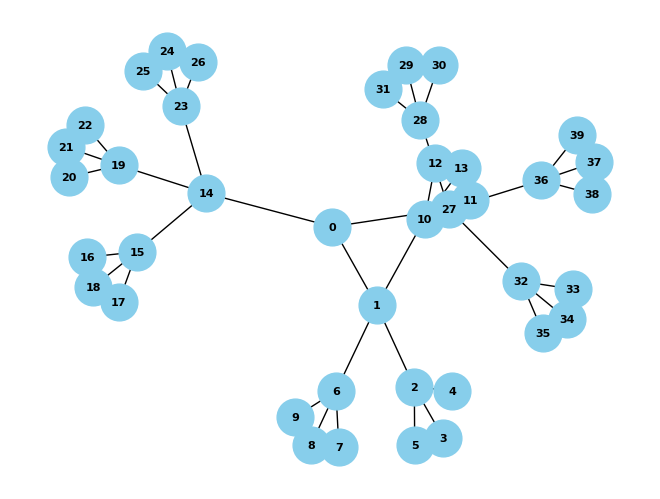

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_tree(depth, max_degree):
    G = nx.Graph()
    node_count = 1

    def add_nodes(parent, depth):
        nonlocal node_count
        if depth == 0:
            return
        for i in range(max_degree):
            child = node_count
            node_count += 1
            G.add_edge(parent, child)
            add_nodes(child, depth - 1)

    add_nodes(0, depth)
    return G

depth = 3  # Specify the depth of the tree
max_degree = 3  # Specify the maximum degree of each node

tree = generate_tree(depth, max_degree)

# Draw the tree
pos = nx.spring_layout(tree)
nx.draw(tree, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)
plt.show()


In [23]:
print(original_tasks[-6])

Task(
    name='remove-index-k with k=1',
    inputs_dict={'x1': [[4, 8, 11, 0, 8, 11], [14, 13, 8, 15, 8, 10, 0, 6], [8, 10, 12, 11, 8, 8], [4, 4, 12, 7, 13, 9, 1], [13, 4, 11, 10, 5], [12, 14, 15, 4, 8, 1, 0, 10], [0, 10, 4, 11, 14], [13], [10], [2, 8, 12], [1], [12, 15, 10, 10, 3, 8, 1], [6, 10, 8, 14, 2, 12], [6, 0], [16]]},
    outputs=[[8, 11, 0, 8, 11], [13, 8, 15, 8, 10, 0, 6], [10, 12, 11, 8, 8], [4, 12, 7, 13, 9, 1], [4, 11, 10, 5], [14, 15, 4, 8, 1, 0, 10], [10, 4, 11, 14], [], [], [8, 12], [], [15, 10, 10, 3, 8, 1], [10, 8, 14, 2, 12], [0], []],
    solution=None
)


In [19]:
for task in original_tasks:
    if "Fold" in task.solution.expression():
        print(task.solution.expression())

Fold((lambda u1, u2: ((lambda v1: Multiply(v1, v1)))(u2)), Length(x1), Cdr(Cdr(Cdr(x1))))
Cons(Fold((lambda u1, u2: ((lambda v1: Subtract(1, v1)))(u1)), Add(1, 1), x1), [])
Fold((lambda u1, u2: ((lambda v1: Fold((lambda u1, u2: []), Cons(0, x1), v1)))(u1)), x1, Cdr(x1))
Cdr(Fold((lambda u1, u2: ((lambda v1: Cons(1, v1)))(u1)), Cons(Length(x1), x1), x1))
Mod(Car(x1), Fold((lambda u1, u2: ((lambda v1, v2: Subtract(v1, v2)))(u1, u2)), 1, x1))
Cons(0, Fold((lambda u1, u2: ((lambda v1: Cons(0, v1)))(u1)), Cdr(Cdr(x1)), x1))
Cons(Fold((lambda u1, u2: ((lambda v1: Subtract(v1, 1)))(u2)), 0, Cdr(Cdr(x1))), [])
Fold((lambda u1, u2: ((lambda v1: Mod(v1, Subtract(Car(x1), 1))))(u2)), [], Cdr(x1))
Fold((lambda u1, u2: ((lambda v1: Subtract(v1, Add(1, Length(x1)))))(u2)), 1, Cdr(x1))
Fold((lambda u1, u2: ((lambda v1: Cons(v1, Cdr(Map((lambda u1: 1), x1)))))(u2)), 1, Cdr(x1))
Fold((lambda u1, u2: ((lambda v1: Subtract(Length(Cdr(x1)), v1)))(u1)), 1, Cdr(Cdr(x1)))
Fold((lambda u1, u2: ((lambda v1: Mo

In [65]:
for task in original_tasks:
    print(task)

Task(
    name='add-k with k=5',
    inputs_dict={'x1': [[7, 4, 11], [6, 13, 0, 2], [3, 6], [7, 7, 0], [5, 14, 10, 15, 6], [16, 12, 15, 7], [7, 6, 11], [10, 8, 4, 7], [12], [5], [16, 13, 9, 13, 0, 3, 10], [4, 5, 4, 0, 8, 9], [3, 14, 15, 0, 12, 0], [13, 8, 10], [9, 6, 5, 0, 7, 7]]},
    outputs=[[12, 9, 16], [11, 18, 5, 7], [8, 11], [12, 12, 5], [10, 19, 15, 20, 11], [21, 17, 20, 12], [12, 11, 16], [15, 13, 9, 12], [17], [10], [21, 18, 14, 18, 5, 8, 15], [9, 10, 9, 5, 13, 14], [8, 19, 20, 5, 17, 5], [18, 13, 15], [14, 11, 10, 5, 12, 12]],
    solution=None
)
Task(
    name='append-index-k with k=1',
    inputs_dict={'x1': [[0, 14, 6], [0, 1, 7], [7, 5, 16, 3], [10, 0, 8, 6, 4, 9, 7, 7], [12, 7, 2, 2, 9, 11, 14], [4], [11, 7, 6, 4, 9, 4, 15, 16], [3, 5, 0], [10], [15, 4, 3], [8, 10, 0, 16], [12], [16, 2, 5], [1, 4, 8, 4, 0, 16, 13], [13, 14, 9, 10, 15, 3, 9, 15]]},
    outputs=[[0, 14, 6, 0], [0, 1, 7, 0], [7, 5, 16, 3, 7], [10, 0, 8, 6, 4, 9, 7, 7, 10], [12, 7, 2, 2, 9, 11, 14, 12], [4,

In [4]:
ma_tasks = []
for task in original_tasks:
    if "pow" in task.name or task.name == "remove empty lists":
        continue
    ma_tasks.append(task)

In [5]:
len(ma_tasks)

104

In [6]:
import pickle
with open("/work/ldierkes/repos/new/LambdaBeam/crossbeam/data/dreamcoder_test_tasks.pkl", 'wb') as file:
    pickle.dump(ma_tasks, file)

In [6]:
from functools import reduce
xs = [1,2,3,4,5]
n = 0
f = lambda x, y: x + y

reduce(lambda x, y: f(x)(y), xs[::-1], n)

TypeError: <lambda>() missing 1 required positional argument: 'y'